# Random Forest
This notebook will work through creating the RF code.

In [1]:
%pip install pandas numpy xgboost sklearn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, make_scorer
from sklearn import metrics
import pandas as pd
import numpy as np

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import f1_score


## Set up all variables needed for RF
The set of variables below are needed for RF.

In [47]:
max_depth=40
min_samples_leaf=1
min_samples_split=40
num_classes=19

## Load data
Load the preprocessed training/testing data

In [4]:
ompk35 = pd.read_csv("../data/processed/form_3_ompk35.csv", index_col=0)
ompk36 = pd.read_csv("../data/processed/form_3_ompk36.csv", index_col=0)
ompk37 = pd.read_csv("../data/processed/form_3_ompk37.csv", index_col=0)



labels = pd.read_csv("../data/processed/labels.csv", index_col=0)
set_mics = pd.read_csv("../data/processed/mic_set.csv")

## Rename columns
We will be merging all columns together and performing an inner join on the rows. In order to do that, we need to make sure all columns for each gene have different names. Otherwise, the columns will be merged.

In [5]:
def set_columns(df, gene_name):
    df = df.set_axis([i for i in range(len(df.columns))], axis=1)
    df = df.add_prefix(f'{gene_name}_')
    return df

In [6]:
ompk35 = set_columns(ompk35, 'ompk35')
ompk36 = set_columns(ompk36, 'ompk36')
ompk37 = set_columns(ompk37, 'ompk37')

In [7]:
form_3 = pd.concat([ompk35, ompk36, ompk37], axis=1, join='inner')

In [8]:
form_3.head()

,ompk35_0,ompk35_1,ompk35_2,ompk35_3,ompk35_4,ompk35_5,ompk35_6,ompk35_7,ompk35_8,ompk35_9,...,ompk37_375,ompk37_376,ompk37_377,ompk37_378,ompk37_379,ompk37_380,ompk37_381,ompk37_382,ompk37_383,ompk37_384
Name,,,,,,,,,,,,,,,,,,,,,
Sentry-2016-958127,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22
Sentry-2016-965615,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22
Sentry-2016-965666,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22
Sentry-2016-977317,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22
Sentry-2017-1024192,12,12,23,24,24,24,24,24,24,24,...,19,0,10,7,10,19,18,5,13,22


## Setting labels
The labels contain all isolates that have no holes for at least 1 gene. However, we want to get isolates that have no holes for all genes. For that, we will need to shrink the list of labels down to only have isolates that are in `form_3` variable.

In [9]:
# Show that the numbers are off
print(len(labels.index))
print(len(form_3.index))

2864
1225


In [10]:
labels = labels[labels.index.isin(form_3.index)]

In [11]:
# Show that the numbers match now
print(len(labels.index))
print(len(form_3.index))

1225
1225


## Sorting data and labels
The labels and data must be in sorted order when training. Otherwise, the an MIC value could be matched up with the wrong datapoint.

In [12]:
labels = labels.sort_index()
form_3 = form_3.sort_index()
labels

,Antibiotic_1,Antibiotic_2,Antibiotic_3,Antibiotic_4,Antibiotic_5
Name,,,,,
Sentry-2016-933272,6,8,0,8,8
Sentry-2016-933582,6,7,0,5,6
Sentry-2016-934829,13,7,0,12,14
Sentry-2016-935518,13,7,0,12,14
Sentry-2016-935530,12,7,0,5,12
...,...,...,...,...,...
Sentry-2018-1087789,17,7,13,5,14
Sentry-2018-1087802,13,7,13,5,13
Sentry-2018-1087818,17,9,12,6,14


## Cross Validation
This next section will create the needed  decison matrices and perform cross validation to see how well XGBoost can predict. There are only 2 datapoints, so it is not work much, but it at least makes sure the code works.

In [13]:
model = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)

# Update 2 (use correct classes when testing and showing output)
I forgot that each antibiotic will have different MICs assocciated with it. We need to get a sorted list of what MIC values are found to be used for ROC and F1 score later.

In [61]:
# Get and save the classes used for later
classes = labels['Antibiotic_1'].unique()
classes.sort()

In [74]:
# Cross Validation (must be 2 since we only have 2 datapoints)
cv_results = cross_val_score(model, form_3, labels['Antibiotic_1'], cv=5, scoring='f1_micro')
print(cv_results)
cv_df = pd.DataFrame([cv_results], columns=["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"])


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[0.54285714 0.55102041 0.54693878 0.55918367 0.54285714]


# Train a model
Train a model.

In [63]:
model.fit(form_3, labels['Antibiotic_1'])

RandomForestClassifier(max_depth=40, min_samples_split=40)

# Make some predicitons and see ROC and AUROC
Next is making some predictions and getting an overall performance of the model.

In [64]:
# Normally use can use "predict" for which would give exact output, but we want probabilities for ROC.
predictions = model.predict_proba(form_3)

## Binarize labels
Need to binarize the labels for ROC functions

In [66]:
binary_labels = label_binarize(labels['Antibiotic_1'], classes=[i for i in classes])
print(binary_labels.shape)
print(f"({len(predictions)}, {len(predictions[0])})")

(1225, 15)
(1225, 15)


## Get False Positive and True Positive rates
For ROC, we need FPR and TPR to plot the ROC curve and get Area Under that curve, the next part gets those values as well as the Area Under for each class.

In [67]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

## Micro average
Since we have a multi-class problem, we need to average all ROC's together. The best average to take is micro average.

In [68]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(binary_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

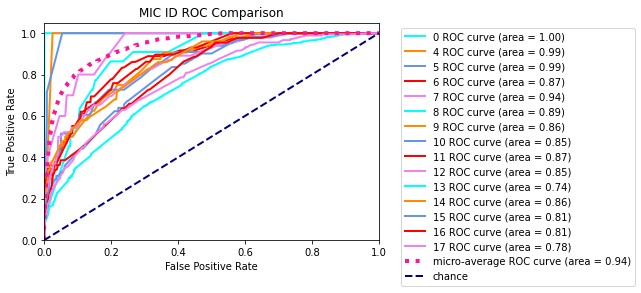

In [71]:
plt.figure()

# Plot all available labels
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'violet'])
for i, color in zip(range(len(classes)), colors):
    # A curve will not be shown if TPR contains nans.
    if not np.isnan(tpr[i]).any():
        plt.plot(fpr[i], tpr[i], color=color,
                lw=2, label=f'{classes[i]} ROC curve (area = {roc_auc[i]:0.2f})')

# Plot micro average
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Plot chance line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="chance")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MIC ID ROC Comparison')
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.show()

# Saving the model
Now to save the model for later

## Save as binary
The next line saves the model as a binary file that can be loaded in and used again later for predicting.

In [76]:
# Save the model in a form that can be loaded and used later
import joblib
joblib.dump(model, "rf.joblib")

['rf.joblib']

# Feature importance
Lastly, there is finding and plotting the feature importances. Which column(s) were the most important in predicting the MIC value? We want to have the bar graph sorted, so first we will get a list of sorted indecies and use that to make the plot.

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.58263164e-04
 8.61419588e-05 5.98630218e-04]


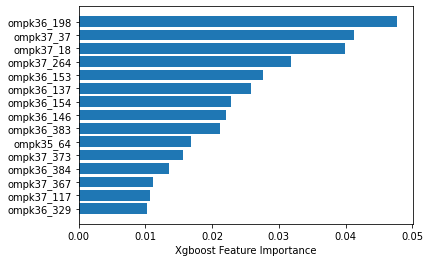

In [77]:
# Get and sort feature importances
importance_values = np.array(model.feature_importances_)
print(importance_values)
sorted_idx = np.argsort(importance_values)
sorted_feature_names = np.array(form_3.columns)[sorted_idx]
sorted_features = importance_values[sorted_idx]


# Get top 15 features
plt.barh(sorted_feature_names[-15:], sorted_features[-15:])
plt.xlabel("RF Feature Importance")
plt.show()

## Save entire feature list to csv
Save the feature importance values to a CSV file.
> NOTE: Taken from: [https://stackoverflow.com/a/50902721](https://stackoverflow.com/a/50902721)

In [78]:
items = []
for g, i in zip(form_3.columns, model.feature_importances_):
    items.append([g, i])

rf_fea_imp=pd.DataFrame(items,
                        columns=['feature','importance']).sort_values('importance', ascending=False)
print('',rf_fea_imp)
rf_fea_imp.to_csv('rf_fea_imp.csv', index=False)

          feature  importance
559   ompk36_198    0.047769
801    ompk37_37    0.041255
782    ompk37_18    0.039989
1028  ompk37_264    0.031826
514   ompk36_153    0.027605
...          ...         ...
678   ompk36_317    0.000000
166   ompk35_166    0.000000
162   ompk35_162    0.000000
161   ompk35_161    0.000000
0       ompk35_0    0.000000

[1149 rows x 2 columns]


## Not all gene Amino Acids used
Note that out of the 1149 Amino Acids in the preprocessing folder, only 111 were used.

In [47]:
y_pred = np.argmax(predictions, axis=1)
y_true = labels['Antibiotic_1'].values

In [48]:
f1 = pd.DataFrame([], columns=['antibiotic', 'f1_score', 'mic', 'ml'])
for m in ['xgboost', 'rf', 'nn']:
    for a in ["Antibiotic_1", "Antibiotic_2", "Antibiotic_3"]:
        scores = f1_score(y_true, y_pred, average=None, labels=range(num_classes))
        for i, s in enumerate(scores):
            if i in y_true:
                f1 = f1.append({'antibiotic': a, 'f1_score': s, 'mic': i, 'ml': m}, ignore_index=True)

f1.head()

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1492: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_divisio

,antibiotic,f1_score,mic,ml
0,Antibiotic_1,0.000000,0,xgboost
1,Antibiotic_1,0.000000,4,xgboost
2,Antibiotic_1,0.000000,5,xgboost
3,Antibiotic_1,0.170213,6,xgboost
4,Antibiotic_1,0.000000,7,xgboost


In [49]:
f1_score(y_true, y_pred, average='micro')

0.5697959183673469

# Plot F1 scores
The F1 scores can then be plotted 

The code to add text to the graph can be found [here from StackOverflow](https://stackoverflow.com/a/55157558).

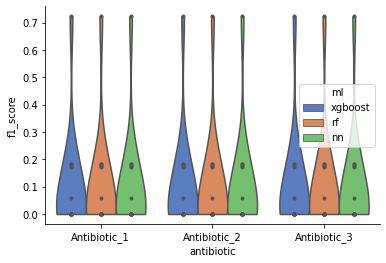

In [55]:
import seaborn as sns
# import random
# antibiotics = list(f1['antibiotic'].unique())
# mls = list(f1['ml'].unique())
g = sns.violinplot(x="antibiotic", y="f1_score", data=f1, inner='point', hue='ml', cut=0, scale="count", palette="muted")
#ax.get_legend().remove()
sns.despine() # Remove the top and right graph lines
#ax = sns.stripplot(x='antibiotic', y='f1_score', data=f1, jitter=True, edgecolor='none', alpha=.40, hue='ml')
#ax2 = sns.swarmplot(x='antibiotic', y='f1_score', data=f1, dodge=True, edgecolor='none', alpha=.40, hue='ml')

#for j, a in enumerate(antibiotics):
#    for k, m in enumerate(mls):
#        if k == 0:
#            m_diff = -0.25
#        elif k == 1:
#            m_diff = 0
#        else:
#            m_diff = 0.25
#        mics = f1[(f1['antibiotic'] == a) & (f1['ml'] == m)]
#        flag = True
#        for i in range(len(mics)):
#            if flag is True:
#                delta = 0.1
#                align = 'left'
#                flag = False
#            else:
#                delta = -0.1
#                align = 'right'
#                flag = True
#            g.text(x=j+m_diff+delta, y=mics['f1_score'].values[i], s=mics['mic'].values[i], horizontalalignment=align, size='small', color='black')

